In [1]:
import csv
from scipy import ndimage
from scipy import linalg
import numpy as np
import nibabel as nib
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from operator import itemgetter
import pickle

In [2]:
import random

index = np.array(range(416))
random.seed(40)
random.shuffle(index)

train_index = index[0:291]
val_index = index[291:333]
test_index = index[333:416]

In [3]:
lab = np.zeros((416,1)) #first AD:188 then CN:288
lab[0:188, 0] = 1 #AD -- 1; CN -- 0

In [4]:
ad = 0.
cn = 0.
total_num = 0.
for i in lab:
    if(i == 1):
        ad += 1
    elif(i == 0):
        cn += 1
total_num = ad + cn
print(ad, cn, total_num)

188.0 228.0 416.0


In [5]:
from torch.utils.data import Dataset, DataLoader

def ToTensor(np_array):
    tensor = torch.from_numpy(np_array)
    tensor = tensor.float()
    return tensor

class ADNI_Dataset(Dataset):
    
    def __init__(self, ptype, transform=None):
        
        self.ptype = ptype
        
        self.img = np.load('GRAY_AD_CN_Jan25.npy') # 416 * ((121 * 121) * 3)
        self.lab = np.zeros((416,1)) #first AD:188 then CN:288
        self.lab[0:188, 0] = 1 #AD -- 1; CN -- 0

        if(self.ptype == 'train'):
            self.img = self.img[train_index]
            self.lab = self.lab[train_index]
        if(self.ptype == 'val'):
            self.img = self.img[val_index]
            self.lab = self.lab[val_index]
        if(self.ptype == 'test'):
            self.img = self.img[test_index]
            self.lab = self.lab[test_index]        

    def __len__(self):#return int: number of mri
        return len(self.img)

    def __getitem__(self, idx):#input the dataset and desires i-th item
       
        sample = {'image': self.img[idx], 'labels': self.lab[idx,0]} 

        return sample


In [6]:
ADNI_Data_train = ADNI_Dataset('train')

ADNI_Data_val = ADNI_Dataset('val')

ADNI_Data_test = ADNI_Dataset('test')



dataloader_train = DataLoader(ADNI_Data_train, batch_size=400,
                        shuffle=True, num_workers=4)
dataloader_val = DataLoader(ADNI_Data_val, batch_size=400,
                        shuffle=True, num_workers=4)
dataloader_test = DataLoader(ADNI_Data_test, batch_size=400,
                        shuffle=True, num_workers=4)


In [7]:
import torch.nn as nn
import torch.nn.functional as F

#initial: 
#121 * 121 * 3(feature map number)
#60 * 60 * 16
#30 * 30 * 32
#15 * 15 * 64
#7 * 7 * 128
#3 * 3 * 256

#Linear: 3 * 3 * 256
#3 * 3 * 256(2304)--->1024 --->256 ---> 64 --->2 
class Net_2D(nn.Module):
    def __init__(self):
        super(Net_2D, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5, padding=2)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
        self.conv4 = nn.Conv2d(64, 128, 5, padding=2)
        self.conv5 = nn.Conv2d(128, 256, 5, padding=2)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(3 * 3 * 256, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 2)

    def forward(self, x): #batch_size * 256*256*160*1
        x = self.pool(F.relu(self.conv1(x)))#batch_size * 128 * 128 * 80 * 2
        x = self.pool(F.relu(self.conv2(x)))#batch_size * 64 * 64 * 40 * 4
        x = self.pool(F.relu(self.conv3(x)))#batch_size * 32 * 32 * 20 * 8
        x = self.pool(F.relu(self.conv4(x)))#batch_size * 16 * 16 * 10 * 16
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(-1, 3 * 3 * 256)#batch_size * 10240(8*8*5*32)
        x = F.relu(self.fc1(x))#batch_size * 1024
        x = F.relu(self.fc2(x))#batch_size * 256
        x = F.relu(self.fc3(x))#batch_size * 64
        x = self.fc4(x)#batch_size * 3
        return x

net_2d = Net_2D().cuda()

print("finished")

finished


In [8]:
import torch.optim as optim
import torch 
Weight = torch.tensor([total_num / cn, total_num / ad])
criterion = nn.CrossEntropyLoss(weight = Weight.cuda())
optimizer = optim.SGD(net_2d.parameters(), lr=0.005, momentum=0.9)

In [10]:
import numpy as np
import torch

def ToTensor(np_array):
    tensor = torch.from_numpy(np_array)
    tensor = tensor.float()
    return tensor

Validation_loss = []
Training_loss = []
epoch_actual = 0

loss_val_min = 1000000
threshold = 30

epoch = 50000
min_total_loss = 1000000


for i in range(epoch):
    epoch_actual += 1
    for i_batch, sample_batched in enumerate(dataloader_train):
        
        labels = sample_batched['labels'].cuda()
        
        running_loss = 0.0

        images = sample_batched['image'].float().cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        #before actual training
        net_2d.train()

        # forward + backward + optimize
        outputs = net_2d(images)
       
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        # print statistics
        print('[%d] loss: %.3f' %
                (i_batch + 1, loss.item()))
        Training_loss.append(loss.item())
    print('$$Finished Training This Epoch')
    
    #validation for the epoch
    net_2d.eval()
    total_val_loss = 0
    print('Start a new val_epoch')
    for i_batch, sample_batched in enumerate(dataloader_val):
        print(i_batch)
        
        running_loss = 0.0
        
        labels = sample_batched['labels'].cuda()
        images = sample_batched['image'].float().cuda()
       
        outputs = net_2d(images)
        loss = criterion(outputs, labels.long())
        print('Validation')
        print('[%d] loss: %.3f' %
                (i_batch + 1, loss.item()))
        Validation_loss.append(loss.item())
        print('\n')

        total_val_loss = total_val_loss + loss.cpu().data.numpy()

        if(total_val_loss < min_total_loss):
            min_total_loss = total_val_loss
    if(total_val_loss >= loss_val_min):
        if(total_val_loss < 0.5):
            count += 1
    else:
        loss_val_min = total_val_loss
        count = 0
        torch.save(net_2d, 'best_model_Feb10_NOISE_weighted_AD_CN_plot_val_loss.pkl')
        
    if(count > threshold):
        break
print("we're done training")

[1] loss: 0.693
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.696




/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Net_2D. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


[1] loss: 0.693
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.696


[1] loss: 0.693
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.696


[1] loss: 0.693
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.696


[1] loss: 0.693
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.696


[1] loss: 0.693
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.696


[1] loss: 0.693
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.696


[1] loss: 0.693
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.696


[1] loss: 0.693
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.696


[1] loss: 0.692
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.696


[1] loss: 0.692
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.696




[1] loss: 0.692
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.697


[1] loss: 0.692
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.697


[1] loss: 0.692
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.697


[1] loss: 0.692
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.697


[1] loss: 0.692
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.697


[1] loss: 0.692
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.697


[1] loss: 0.692
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.697


[1] loss: 0.692
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.697


[1] loss: 0.692
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.697


[1] loss: 0.692
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.697




[1] loss: 0.692
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.697


[1] loss: 0.692
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.697


[1] loss: 0.692
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.697


[1] loss: 0.692
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.697


[1] loss: 0.692
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.697


[1] loss: 0.692
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.697


[1] loss: 0.692
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.697


[1] loss: 0.692
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.697


[1] loss: 0.692
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.697


[1] loss: 0.692
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.697




[1] loss: 0.691
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.696


[1] loss: 0.691
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.696


[1] loss: 0.691
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.696


[1] loss: 0.691
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.696


[1] loss: 0.691
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.696


[1] loss: 0.691
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.696


[1] loss: 0.691
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.696


[1] loss: 0.691
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.696


[1] loss: 0.691
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.696


[1] loss: 0.691
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.696




[1] loss: 0.690
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.695


[1] loss: 0.690
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.695


[1] loss: 0.690
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.695


[1] loss: 0.690
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.695


[1] loss: 0.690
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.695


[1] loss: 0.690
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.695


[1] loss: 0.690
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.695


[1] loss: 0.690
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.695


[1] loss: 0.690
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.695


[1] loss: 0.690
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.695




[1] loss: 0.683
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.687


[1] loss: 0.682
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.687


[1] loss: 0.682
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.687


[1] loss: 0.682
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.686


[1] loss: 0.682
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.686


[1] loss: 0.681
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.686


[1] loss: 0.681
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.685


[1] loss: 0.681
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.685


[1] loss: 0.680
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.685


[1] loss: 0.680
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.684




[1] loss: 0.000
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.000


[1] loss: 0.000
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.000


[1] loss: 0.000
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.000


[1] loss: 0.000
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.000


[1] loss: 0.000
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.000


[1] loss: 0.000
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.000


[1] loss: 0.000
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.000


[1] loss: 0.000
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.000


[1] loss: 0.000
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.000


[1] loss: 0.000
$$Finished Training This Epoch
Start a new val_epoch
0
Validation
[1] loss: 0.000




In [11]:
import torch
#testing after finish all epochs

#load the best_model back 
final_net = torch.load('best_model_Feb10_NOISE_weighted_AD_CN_plot_val_loss.pkl')
final_net.eval()
correct_sum = 0.
total_sum = 0.
for i_batch, sample_batched in enumerate(dataloader_test):
    print(i_batch)

    running_loss = 0.0
    labels = sample_batched['labels'].cuda()
    
    images = sample_batched['image'].float().cuda()

    outputs = final_net(images)#n * 3
    results_type = np.argmax(outputs.cpu().data.numpy(), axis=1)
    results_type = ToTensor(results_type)
    print(outputs)

    #calculate accuracy
    labels = labels.cpu()
    print("\n", results_type, " ", labels)

AD_num = 0
CN_num = 0
for results in results_type:
    if (results.float() == 1):
        AD_num += 1
    if (results.float() == 0):
        CN_num += 1
print(AD_num, CN_num)       

########
for i in range(len(results_type)):
    if(labels[i].float() == results_type[i].float()):
        correct_sum += 1

correct_sum_AD = 0
correct_sum_CN = 0

AD_num = 0
CN_num = 0
for results in results_type:
    if (results.float() == 1):
        AD_num += 1
    if (results.float() == 0):
        CN_num += 1
print("labels", AD_num, CN_num)

for i in range(len(results_type)):
    if(labels[i].float() == results_type[i].float()):
        if(results_type[i].float() == 1):
            correct_sum_AD += 1
    if(labels[i].float() == results_type[i].float()):
        if(results_type[i].float() == 0):
            correct_sum_CN += 1
    total_sum += 1
    
print("correct_sum", correct_sum)
print("correct_sum_AD", correct_sum_AD)
print("correct_sum_CN", correct_sum_CN)
print(total_sum)

0
tensor([[-13.9341,  11.3484],
        [-15.4248,  13.3552],
        [  6.4351, -13.5101],
        [  8.4068, -15.6180],
        [-11.5826,   8.9898],
        [  7.9531, -14.8293],
        [  8.0100, -15.1939],
        [  7.6258, -14.3421],
        [-13.1326,  10.5238],
        [-11.8591,   8.8700],
        [  7.4835, -15.1372],
        [  8.1178, -15.5749],
        [-13.1283,  10.3996],
        [-11.5876,   9.1597],
        [-11.2766,   9.2927],
        [  6.4886, -13.2321],
        [  7.5558, -14.9525],
        [  7.7291, -14.4856],
        [ -9.2370,   6.4612],
        [  7.0877, -13.9184],
        [  8.0070, -15.0028],
        [-12.2144,  10.0848],
        [ -9.7517,   6.5438],
        [-12.2091,   9.8814],
        [  7.7228, -15.1169],
        [ -6.7047,   3.5249],
        [-12.2589,   9.8391],
        [  9.0689, -16.7106],
        [  7.0053, -13.7457],
        [  6.8617, -13.7135],
        [-13.5759,  11.0177],
        [  7.7721, -14.2509],
        [  6.2300, -13.1986],
        

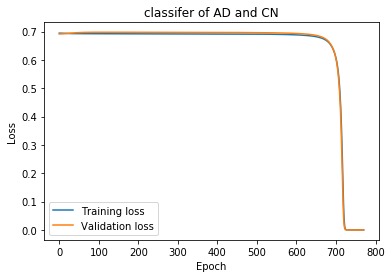

In [16]:
import matplotlib.pyplot as plt 

x1 = range(epoch_actual)
y1 = Training_loss

x2 = range(epoch_actual)
y2 = Validation_loss

plt.plot(x1, y1, label = "Training loss") 
plt.plot(x2, y2, label = "Validation loss") 
plt.title('classifer of AD and CN')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend() 
plt.show() 